# HW6

In [30]:
# Common imports
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import sklearn.metrics as met
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The LendingClub is a peer-to-peer lending company that directly connects borrowers and 
potential lenders/investors. In this homework, you will build classification models to predict 
whether or not a loan provided by LendingClub is likely to default. 
 
In this homework you will use data from the LendingClub to predict whether a loan will be paid 
off in full or the loan will be charged off and possibly go into default.

# Load the Lending Club dataset 
 
Load the dataset into a data frame named loans.

In [31]:
loans = pd.read_csv("lending-club-data.csv")
loans.head()

C:\Users\anson\AppData\Local\Temp\ipykernel_28972\3382603300.py:1: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  loans = pd.read_csv("lending-club-data.csv")


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.14350,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.39320,20161201T000000,1,1,1
2,1077175,1313524,2400,2400,2400,36 months,15.96,84.33,C,C5,...,1.0,1.0,1.0,1.0,0,8.25955,20141201T000000,1,1,1
3,1076863,1277178,10000,10000,10000,36 months,13.49,339.31,C,C1,...,0.2,1.0,1.0,1.0,0,8.27585,20141201T000000,0,1,1
4,1075269,1311441,5000,5000,5000,36 months,7.90,156.46,A,A4,...,0.8,1.0,1.0,1.0,0,5.21533,20141201T000000,1,1,1


### Exploring features 
 
Let's quickly explore what the dataset looks like. First, print out the column names to see what 
features we have in this dataset. Here, we should see that we have some feature columns that 
have to do with grade of the loan, annual income, home ownership status, etc.

In [32]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           122607 non-null  int64  
 1   member_id                    122607 non-null  int64  
 2   loan_amnt                    122607 non-null  int64  
 3   funded_amnt                  122607 non-null  int64  
 4   funded_amnt_inv              122607 non-null  int64  
 5   term                         122607 non-null  object 
 6   int_rate                     122607 non-null  float64
 7   installment                  122607 non-null  float64
 8   grade                        122607 non-null  object 
 9   sub_grade                    122607 non-null  object 
 10  emp_title                    115767 non-null  object 
 11  emp_length                   118516 non-null  object 
 12  home_ownership               122607 non-null  object 
 13 

Features for the classification algorithm 
 
In this assignment, we will be using a subset of features (categorical and numeric). The features 
we will be using are described below. Extract these feature columns and target column from the 
dataset. We will only use these features. 
 
features = [
            
            'grade',                     # grade of the loan 

            'sub_grade',                 # sub-grade of the loan 

            'short_emp',                 # one year or less of employment 

            'emp_length_num',            # number of years of employment 

            'home_ownership',            # home_ownership status: own, mortgage or rent 

            'dti',                       # debt to income ratio 

            'purpose',                   # the purpose of the loan 

            'term',                      # the term of the loan 

            'last_delinq_none',          # has borrower had a delinquincy 

            'last_major_derog_none',     # has borrower had 90 day or worse rating 

            'revol_util',                # percent of available credit being used 

            'total_rec_late_fee',        # total late fees received to day 
           ] 
 
You may skip observations with missing values in these features.

In [33]:
data = loans.copy()
data = data[["grade","sub_grade","short_emp","emp_length_num","home_ownership","dti","purpose",
             "term","last_delinq_none","last_major_derog_none","revol_util","total_rec_late_fee",
             "bad_loans"]]
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122607 entries, 0 to 122606
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   grade                  122607 non-null  object 
 1   sub_grade              122607 non-null  object 
 2   short_emp              122607 non-null  int64  
 3   emp_length_num         122607 non-null  int64  
 4   home_ownership         122607 non-null  object 
 5   dti                    122607 non-null  float64
 6   purpose                122607 non-null  object 
 7   term                   122607 non-null  object 
 8   last_delinq_none       122607 non-null  int64  
 9   last_major_derog_none  122607 non-null  int64  
 10  revol_util             122607 non-null  float64
 11  total_rec_late_fee     122607 non-null  float64
 12  bad_loans              122607 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 12.2+ MB


In [34]:
data.isna().sum()

grade                    0
sub_grade                0
short_emp                0
emp_length_num           0
home_ownership           0
dti                      0
purpose                  0
term                     0
last_delinq_none         0
last_major_derog_none    0
revol_util               0
total_rec_late_fee       0
bad_loans                0
dtype: int64

### Exploring the target column 
 
The target column (label column) of the dataset that we are interested in is called bad_loans. In 
this column 1 means a risky (bad) loan 0 means a safe loan. 

In [35]:
y = data["bad_loans"]
y

0         0
1         1
2         0
3         0
4         0
         ..
122602    1
122603    0
122604    1
122605    1
122606    0
Name: bad_loans, Length: 122607, dtype: int64

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Now, let us explore the distribution of the target column. This gives us a sense of how many safe 
and risky loans are present in the dataset. Print out the percentage of safe loans and risky loans in 
the data frame. 
 
It looks like most of these loans are safe loans (thankfully). But this does make our problem of 
identifying risky loans challenging. 

In [37]:
# Calculate the percentage using value_counts
frequency_table = y.value_counts(normalize=True).reset_index()
frequency_table.columns = ['Value', 'Percentage']

# Print the table of percentage
print(frequency_table)

   Value  Percentage
0      0    0.811185
1      1    0.188815


<Axes: xlabel='bad_loans'>

Text(0.5, 0, 'Bad Loan')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Bad Loan Count Bar Graph')

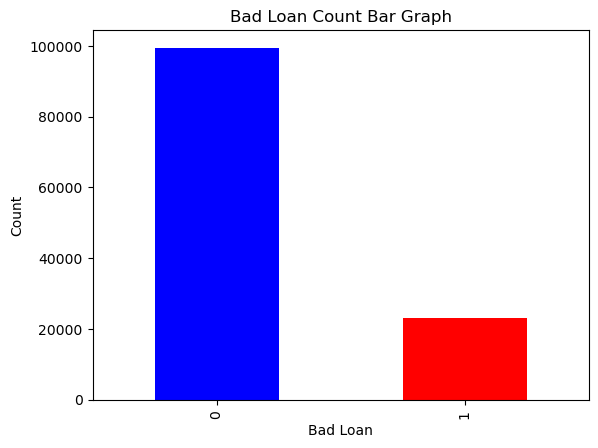

In [38]:
# Plotting a bar graph

y.groupby(y).count().plot(kind='bar', color=['blue', 'red']) 
plt.xlabel('Bad Loan')
plt.ylabel('Count')
plt.title('Bad Loan Count Bar Graph')
plt.show()

### Sample data to balance classes 
 
Our data is disproportionally full of safe loans. Let's create two datasets: one with just the safe 
loans (safe_loans_raw) and one with just the risky loans (risky_loans_raw). 
  
One way to combat class imbalance is to undersample the larger class until the class distribution 
is approximately half and half. Here, we will undersample the larger class (safe loans) in order to 
balance out our dataset. This means we are throwing away many data points. We will use seed=1 
so everyone gets the same results. Use the following codes for this task.  


In [39]:
risky_loans_raw = data[data.bad_loans==1]

In [40]:
risky_loans_raw

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,1
6,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,1
7,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,1
10,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,1
12,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122596,D,D1,0,11,MORTGAGE,19.56,debt_consolidation,36 months,0,1,52.5,0.0,1
122601,B,B5,0,5,MORTGAGE,18.69,debt_consolidation,36 months,0,1,29.5,0.0,1
122602,E,E5,1,0,MORTGAGE,1.50,medical,60 months,0,0,14.6,0.0,1
122604,D,D3,0,6,MORTGAGE,12.28,medical,60 months,0,0,10.7,0.0,1


In [41]:
safe_loans_raw = data[data.bad_loans==0]

In [42]:
safe_loans_raw

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,bad_loans
0,B,B2,0,11,RENT,27.65,credit_card,36 months,1,1,83.7,0.00,0
2,C,C5,0,11,RENT,8.72,small_business,36 months,1,1,98.5,0.00,0
3,C,C1,0,11,RENT,20.00,other,36 months,0,1,21.0,16.97,0
4,A,A4,0,4,RENT,11.20,wedding,36 months,1,1,28.3,0.00,0
5,E,E1,0,10,RENT,5.35,car,36 months,1,1,87.5,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122598,A,A5,0,3,MORTGAGE,14.60,medical,36 months,1,1,82.7,0.00,0
122599,G,G2,0,11,MORTGAGE,26.27,medical,60 months,0,0,94.1,0.00,0
122600,D,D3,1,1,RENT,6.41,other,36 months,0,1,55.9,0.00,0
122603,D,D2,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,0,15.2,0.00,0


In [43]:
percentage = len(risky_loans_raw)/float(len(safe_loans_raw)) 
 
risky_loans = risky_loans_raw 

safe_loans = safe_loans_raw.sample(frac = percentage, random_state = 1) 
 
# Append the risky_loans with the downsampled version of safe_loans 

loans_data = pd.concat([risky_loans, safe_loans], ignore_index=True)

In [44]:
loans_data[loans_data.bad_loans==1].shape

(23150, 13)

In [45]:
loans_data[loans_data.bad_loans==0].shape

(23150, 13)

### One-hot encoding 
 
For scikit-learn's implementation, it requires numerical values for it's data matrix. This means 
you will have to turn categorical variables into binary features via one-hot encoding.

In [46]:
loans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46300 entries, 0 to 46299
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   grade                  46300 non-null  object 
 1   sub_grade              46300 non-null  object 
 2   short_emp              46300 non-null  int64  
 3   emp_length_num         46300 non-null  int64  
 4   home_ownership         46300 non-null  object 
 5   dti                    46300 non-null  float64
 6   purpose                46300 non-null  object 
 7   term                   46300 non-null  object 
 8   last_delinq_none       46300 non-null  int64  
 9   last_major_derog_none  46300 non-null  int64  
 10  revol_util             46300 non-null  float64
 11  total_rec_late_fee     46300 non-null  float64
 12  bad_loans              46300 non-null  int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 4.6+ MB


In [47]:
col_cat = ["grade","sub_grade","home_ownership","purpose","term"]
col_num = ["emp_length_num","dti","revol_util","total_rec_late_fee"]

pipe_num = make_pipeline(StandardScaler(), SimpleImputer())
pipe_cat = make_pipeline(SimpleImputer(strategy = 'constant'), 
                         OneHotEncoder(handle_unknown = 'ignore'))

preprocessor = make_column_transformer( (pipe_cat,col_cat) , (pipe_num,col_num) )

### Split data into training and validation and test sets 
 
First, split the original data into train-validate set (90%) and test set (10%) using random state = 0.  
Then, split the train-validate set into training set (80%) and validation set (20%) using random 
state = 0. 

In [48]:
X = loans_data.drop("bad_loans", axis=1)
y = loans_data["bad_loans"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,y_train_val, test_size=0.2, random_state=0)


### Build a MLP classifier 
 
Use 5-fold GridSearchCV on the train-validate set. Build a MLP classifier and based on accuracy 
compare hyperparameters in the following grid:  
hidden_layer_sizes: [(10,), (50,), (100,), (10, 10), (50, 50)] 

In [49]:
pipe = make_pipeline(preprocessor, MLPClassifier(random_state = 0, max_iter = 1500))
param_grid = {'mlpclassifier__hidden_layer_sizes':
              [(10,), (50,), (100,), (10, 10), (50, 50)] }

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

In [50]:
grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['grade',
                                                                          'sub_grade',
                                                                          'home_ownership',
                                                                          'purpose',
                                                                          'term']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['emp_length_num',
                                                                          'dti',
                                                                          'revol_util',
                                                                          'total_rec_late_fee'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=1500,
                                                      random_state=0))]),
             param_grid={'mlpclassifier__hidden_layer_sizes': [(10,), (50,),
                                                               (100,), (10, 10),
                                                               (50, 50)]},
             return_train_score=True)

In [51]:
results = pd.DataFrame(grid.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.450697,1.208264,0.016004,0.003100,"(10,)","{'mlpclassifier__hidden_layer_sizes': (10,)}",0.636429,0.639069,0.638709,0.640509,...,0.639381,0.001919,1,0.650108,0.649208,0.647348,0.649958,0.648338,0.648992,0.001035
1,24.092881,2.630064,0.017404,0.001856,"(50,)","{'mlpclassifier__hidden_layer_sizes': (50,)}",0.614111,0.613631,0.617951,0.619270,...,0.616679,0.002336,3,0.684185,0.685505,0.680916,0.683525,0.685055,0.683837,0.001614
2,37.497295,4.787869,0.022005,0.002281,"(100,)","{'mlpclassifier__hidden_layer_sizes': (100,)}",0.615311,0.602112,0.613271,0.607871,...,0.610727,0.005074,4,0.708453,0.716103,0.708513,0.714693,0.707823,0.711117,0.003532
3,13.212293,1.625533,0.018521,0.001799,"(10, 10)","{'mlpclassifier__hidden_layer_sizes': (10, 10)}",0.635709,0.639309,0.640869,0.635829,...,0.637077,0.002623,2,0.653258,0.655418,0.654818,0.651008,0.654158,0.653732,0.001539
4,54.464045,7.135667,0.020180,0.002753,"(50, 50)","{'mlpclassifier__hidden_layer_sizes': (50, 50)}",0.599952,0.595632,0.590593,0.590953,...,0.593808,0.003554,5,0.741931,0.742651,0.739501,0.734251,0.740551,0.739777,0.002970


In [52]:
print('Accuracy score is {:.3f}'.format(grid.best_score_))
print('The best accracy is when ',grid.best_params_ )

Accuracy score is 0.639
The best accracy is when  {'mlpclassifier__hidden_layer_sizes': (10,)}


### Report the best model (call it MODEL1)’s accuracy, precision, recall, F1-score, balanced accuracy, ROC-AUC on the test set. Plot the precision-recall curve and the ROC curve.

In [53]:
print(f"The accuracy of model1 is {met.accuracy_score(y_test,grid.predict(X_test)):.4f}")

The accuracy of model1 is 0.6300


In [54]:
print(f"The precision of model1 is {met.precision_score(y_test,grid.predict(X_test)):.4f}")

The precision of model1 is 0.6256


In [55]:
print(f"The recall of model1 is {met.recall_score(y_test,grid.predict(X_test)):.4f}")

The recall of model1 is 0.6297


In [56]:
print(f"The f1 score of model1 is {met.f1_score(y_test,grid.predict(X_test)):.4f}")

The f1 score of model1 is 0.6277


In [57]:
print(f"The balanced accuracy score of model1 is {met.balanced_accuracy_score(y_test,grid.predict(X_test)):.4f}")

The balanced accuracy score of model1 is 0.6300


In [58]:
print(f"The roc_auc score of model1 is {met.roc_auc_score(y_test,grid.predict(X_test)):.4f}")

The roc_auc score of model1 is 0.6300


In [59]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support
import matplotlib.pyplot as plt

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve with Threshold Point')

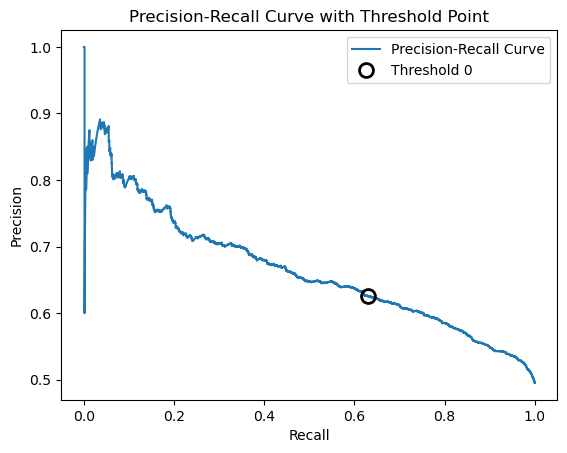

In [60]:
# Assuming you have the true labels (y_test) and predicted probabilities for the positive class (grid.predict_proba(X_test)[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, grid.predict_proba(X_test)[:, 1])

# Calculate precision and recall at a specific threshold (e.g., threshold zero)
threshold_zero = 0  # Adjust this threshold as needed
precision_at_zero, recall_at_zero, _, _ = precision_recall_fscore_support(y_test, grid.predict(X_test) > threshold_zero, average='binary')

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')

# Plot a point at the specific threshold
plt.plot(recall_at_zero, precision_at_zero, 'o', markersize=10, label=f'Threshold {threshold_zero}', fillstyle="none", c='k', mew=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Threshold Point')
plt.legend()
plt.show()

### Will you choose a different model (call it MODEL2) if the GridSearchCV comparison was based on ROC-AUC? Why?

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Threshold Point')

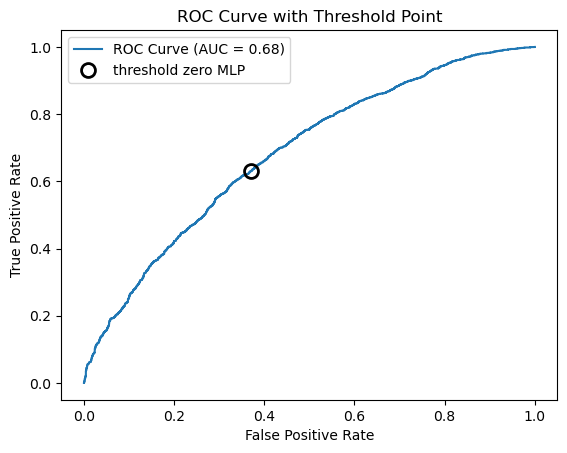

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have the true labels (y_test) and predicted probabilities for the positive class (grid.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

confusion_mlp = confusion_matrix(y_test, grid.predict(X_test), normalize='true')

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.plot(confusion_mlp[0, 1], confusion_mlp[1, 1], 'o', markersize=10,
         label="threshold zero MLP", fillstyle="none", c='k', mew=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Point')
plt.legend()
plt.show()

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

In [63]:
pipe_gb = make_pipeline(preprocessor, GradientBoostingClassifier(max_depth=6))

np.set_printoptions(precision=6, suppress=True)
param_grid = {'gradientboostingclassifier__learning_rate': np.logspace(-2, 0, 3),
              'gradientboostingclassifier__n_estimators': [5, 10, 50, 100, 200, 500]}
param_grid

{'gradientboostingclassifier__learning_rate': array([0.01, 0.1 , 1.  ]),
 'gradientboostingclassifier__n_estimators': [5, 10, 50, 100, 200, 500]}

In [64]:
grid2 = GridSearchCV(pipe_gb, param_grid, cv = 5, return_train_score = True)
grid2.fit(X_train_val, y_train_val)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['grade',
                                                                          'sub_grade',
                                                                          'home_ownership',
                                                                          'purpose',
                                                                          'term']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['emp_length_num',
                                                                          'dti',
                                                                          'revol_util',
                                                                          'total_rec_late_fee'])])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(max_depth=6))]),
             param_grid={'gradientboostingclassifier__learning_rate': array([0.01, 0.1 , 1.  ]),
                         'gradientboostingclassifier__n_estimators': [5, 10, 50,
                                                                      100, 200,
                                                                      500]},
             return_train_score=True)

In [65]:
print('Accuracy score is {:.3f}'.format(grid2.best_score_))
print('The best accracy is when ',grid2.best_params_ )

Accuracy score is 0.641
The best accracy is when  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__n_estimators': 50}


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve with Threshold Point')

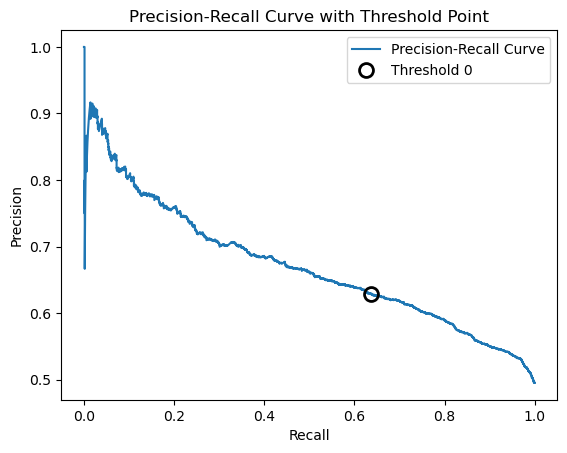

In [66]:
# Assuming you have the true labels (y_test) and predicted probabilities for the positive class (grid.predict_proba(X_test)[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, grid2.predict_proba(X_test)[:, 1])

# Calculate precision and recall at a specific threshold (e.g., threshold zero)
threshold_zero = 0  # Adjust this threshold as needed
precision_at_zero, recall_at_zero, _, _ = precision_recall_fscore_support(y_test, grid2.predict(X_test) > threshold_zero, average='binary')

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')

# Plot a point at the specific threshold
plt.plot(recall_at_zero, precision_at_zero, 'o', markersize=10, label=f'Threshold {threshold_zero}', fillstyle="none", c='k', mew=2)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Threshold Point')
plt.legend()
plt.show()

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve with Threshold Point')

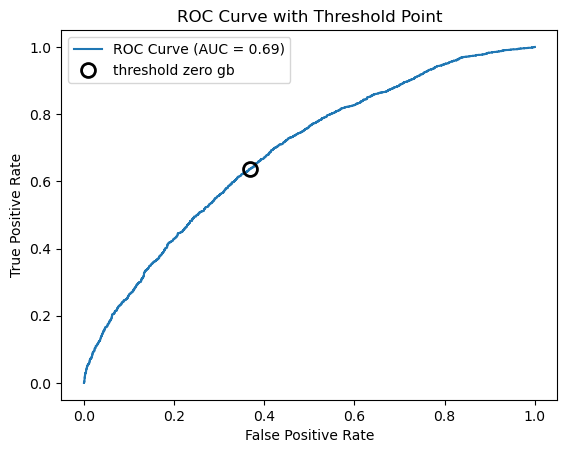

In [67]:
# Assuming you have the true labels (y_test) and predicted probabilities for the positive class (grid.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, grid2.predict_proba(X_test)[:, 1])

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, grid2.predict_proba(X_test)[:, 1])

confusion_mlp = confusion_matrix(y_test, grid2.predict(X_test), normalize='true')

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.plot(confusion_mlp[0, 1], confusion_mlp[1, 1], 'o', markersize=10,
         label="threshold zero gb", fillstyle="none", c='k', mew=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Threshold Point')
plt.legend()
plt.show()

### Quantifying the cost of mistakes 
 
Every mistake the model makes costs money. In this section, we will try and quantify the cost 
each mistake made by the model. Assume the following: 
False negatives: Loans that were actually safe but were predicted to be risky. This results in an 
opportunity cost of losing a loan that would have otherwise been accepted. 
False positives: Loans that were actually risky but were predicted to be safe. These are much 
more expensive because it results in a risky loan being given. 
Correct predictions: All correct predictions don't typically incur any cost. 
 
Let's write code that can compute the cost of mistakes made by the model. Complete the 
following 4 steps: 
First, let us compute the predictions made by the model. 
Second, compute the number of false positives. 
Third, compute the number of false negatives. 
Finally, compute the cost of mistakes made by the model by adding up the costs of true positives 
and false positives. 
 
Let's assume that each mistake costs us money: a false negative costs $10,000, while a false 
positive costs $20,000. What is the total cost of mistakes made by MODEL1 and MODEL2 on 
the test data?

In [68]:
cf_mat = confusion_matrix(y_test, grid.predict(X_test))
cf_mat

array([[1473,  864],
       [ 849, 1444]], dtype=int64)

In [69]:
true_pos = cf_mat[0,0]
true_neg = cf_mat[1,1]
fal_pos = cf_mat[0,1]
fal_neg = cf_mat[1,0]

cost_mistakes = true_pos +fal_pos
cost_mistakes

2337

In [70]:
model1_mistakes = (10000 * fal_neg) + (20000 * fal_pos)
print('Model1 total cost of mistakes:',model1_mistakes)

Model1 total cost of mistakes: 25770000


In [71]:
cf_mat = confusion_matrix(y_test, grid2.predict(X_test))
cf_mat

array([[1475,  862],
       [ 832, 1461]], dtype=int64)

In [72]:
true_pos = cf_mat[0,0]
true_neg = cf_mat[1,1]
fal_pos = cf_mat[0,1]
fal_neg = cf_mat[1,0]

cost_mistakes = true_pos +fal_pos
cost_mistakes

2337

In [73]:
model2_mistakes = (10000 * fal_neg) + (20000 * fal_pos)
print('Model2 total cost of mistakes:',model2_mistakes)

Model2 total cost of mistakes: 25560000


The total cost of mistakes for model 2 is smaller than model 1.

### Optional Question 
 
Can you find another MLP classifier that generates a lower total cost of mistakes?  


In [80]:
pipe = make_pipeline(preprocessor, MLPClassifier(random_state = 0, max_iter = 1500))
param_grid = {'mlpclassifier__hidden_layer_sizes': [(10,), (50,), (100,), (10, 10), (50, 50)], 
             'mlpclassifier__alpha': [0.001, 0.01, 1, 5]}

grid3 = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)

In [81]:
grid3.fit(X_train_val, y_train_val)

results = pd.DataFrame(grid3.cv_results_)
results

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['grade',
                                                                          'sub_grade',
                                                                          'home_ownership',
                                                                          'purpose',
                                                                          'term']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler()),
                                                                                         ('simpleimputer',
                                                                                          SimpleImputer())]),
                                                                         ['emp_length_num',
                                                                          'dti',
                                                                          'revol_util',
                                                                          'total_rec_late_fee'])])),
                                       ('mlpclassifier',
                                        MLPClassifier(max_iter=1500,
                                                      random_state=0))]),
             param_grid={'mlpclassifier__alpha': [0.001, 0.01, 1, 5],
                         'mlpclassifier__hidden_layer_sizes': [(10,), (50,),
                                                               (100,), (10, 10),
                                                               (50, 50)]},
             return_train_score=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mlpclassifier__alpha,param_mlpclassifier__hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.719058,0.752108,0.012603,0.000800,0.001,"(10,)","{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.638349,0.637509,0.639309,...,0.638925,0.001651,7,0.650108,0.649268,0.646928,0.649898,0.647978,0.648836,0.001209
1,19.779214,1.937030,0.014204,0.000400,0.001,"(50,)","{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.616511,0.613871,0.619750,...,0.617423,0.002060,16,0.684935,0.683315,0.680286,0.682415,0.682415,0.682673,0.001507
2,35.610880,5.211080,0.017603,0.001496,0.001,"(100,)","{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.615671,0.604512,0.609071,...,0.610079,0.003643,18,0.699904,0.715293,0.707823,0.712743,0.709443,0.709041,0.005252
3,11.832166,2.979837,0.016721,0.001670,0.001,"(10, 10)","{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.637389,0.639189,0.636189,...,0.636429,0.001745,13,0.653288,0.655898,0.650558,0.649778,0.654938,0.652892,0.002388
4,46.319090,6.021890,0.021005,0.002531,0.001,"(50, 50)","{'mlpclassifier__alpha': 0.001, 'mlpclassifier...",0.594912,0.592513,0.597192,...,0.593449,0.002491,20,0.737161,0.735301,0.734431,0.741091,0.745650,0.738727,0.004151
5,3.799351,0.757430,0.014804,0.003311,0.01,"(10,)","{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.640269,0.638589,0.640269,...,0.639621,0.001467,5,0.648188,0.647558,0.646988,0.649178,0.648128,0.648008,0.000729
6,16.981433,0.867914,0.014197,0.000742,0.01,"(50,)","{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.624670,0.624310,0.621070,...,0.622102,0.002320,15,0.678906,0.677736,0.679086,0.678636,0.672636,0.677400,0.002427
7,36.639405,5.340278,0.020194,0.001595,0.01,"(100,)","{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.619270,0.606431,0.609431,...,0.612815,0.004522,17,0.697684,0.707253,0.702754,0.709473,0.705544,0.704542,0.004072
8,11.120789,2.452841,0.015921,0.003062,0.01,"(10, 10)","{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.633909,0.637269,0.642909,...,0.638709,0.003063,8,0.652868,0.655328,0.649238,0.650798,0.654248,0.652496,0.002224
9,45.744540,3.825447,0.020469,0.002679,0.01,"(50, 50)","{'mlpclassifier__alpha': 0.01, 'mlpclassifier_...",0.598032,0.594432,0.596592,...,0.597240,0.001805,19,0.736861,0.730142,0.736981,0.732091,0.730322,0.733279,0.003051


In [82]:
print('Accuracy score is {:.3f}'.format(grid3.best_score_))
print('The best accracy is when ',grid3.best_params_ )

Accuracy score is 0.642
The best accracy is when  {'mlpclassifier__alpha': 1, 'mlpclassifier__hidden_layer_sizes': (50,)}


In [83]:
cf_mat = confusion_matrix(y_test, grid3.predict(X_test))
cf_mat

array([[1546,  791],
       [ 920, 1373]], dtype=int64)

In [84]:
true_pos = cf_mat[0,0]
true_neg = cf_mat[1,1]
fal_pos = cf_mat[0,1]
fal_neg = cf_mat[1,0]

cost_mistakes = true_pos +fal_pos
cost_mistakes

2337

In [85]:
model3_mistakes = (10000 * fal_neg) + (20000 * fal_pos)
print('Model3 total cost of mistakes:',model3_mistakes)

Model3 total cost of mistakes: 25020000


Model3 has the lowest cost of mistakes among the three.